In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

In [20]:
#Distributive function takes in a grid of data in form of a nxn matrix where each point (i,j) is associated with a weight so that
#A(i,j) = r for some r \in \mathbb{R} and distributes each weight evenly with its neighboring points (into fourths)
def clusterEvenDistribute(A):
    n = int(math.sqrt(A.size)) #Size of matrix
    data_lattice_distribution = A.astype(float)/4 #Initialize the matrix that will contain the even distribution
    weight = np.copy(data_lattice_distribution) #keep a copy for the weight of each point
    for j in range (0,n):
        for i in range(0,n):
            if (i != n-1):
                data_lattice_distribution[i+1][j] = data_lattice_distribution[i+1][j] + weight[i][j]
            if ( j != 0 and i!= n-1):
                data_lattice_distribution[i+1][j-1] = data_lattice_distribution[i+1][j-1] + weight[i][j]
            if (j != 0):
                data_lattice_distribution[i][j-1] = data_lattice_distribution[i][j-1] + weight[i][j]
    return data_lattice_distribution

In [21]:
#CMI smooth takes in two data vectors, and creates bxb grid
def CMI_smooth_v1(x,y,b):
    
    if len(x)==len(y):
        sizeOfVector = len(x)
        
        x_r = ((x-min(x))/(max(x)-min(x)))*b #Let x' be the vector x rescaled on the interval [0,b]
        y_r = ((y-min(y))/(max(y)-min(y)))*b #Let y' be the vector y rescaled on the interval [0,b]
        
        x=x-np.mean(x)
        y=y-np.mean(y)
        
        #smooth data by aligning it with the bXb grid
        x_p = x_r
        y_p = y_r
        for i in range(0,sizeOfVector):
            x_p[i] = np.ceil(x_r[i])
            y_p[i] = np.ceil(y_r[i])
            
        #This will create function distribution which will count the number of points at each grid square
        distribution= [[0 for i in range(b+1)] for i in range(b+1)]
        for j in range (0,b+1):
            for i in range (0, b+1): #For every upper right corner   
                counter = 0
                for k in range (0, sizeOfVector): #For every point data given
                    if (x_p[k]== i) and (y_p[k] == j): #If the point of the data matches the upper right hand corner
                        counter = counter+1 #Then add 1 to the distribution counter
                distribution[i][j] = counter
                
        
        #Now we count the number of points on or below each square to create PXY
        lattice_count = np.asarray(distribution)    # Array of tile data counts
        np.cumsum(lattice_count,axis=1, out=lattice_count)
        np.cumsum(lattice_count, axis=0, out=lattice_count)
        
        #Spread out the data        
        lattice_count = clusterEvenDistribute(lattice_count)
        
        PXY = lattice_count/float(sizeOfVector)
        
        #Calculate CE(X,Y)
        CEXY =0 
        for i in range (1, b+1):
            for j in range (1 ,b+1):
                if (PXY[i][j] != 0):
                    CEXY = CEXY - PXY[i][j]*np.log(PXY[i][j]) 
                    
        #Scale CE(X,Y) back to original data interval
        CEXY= CEXY*(((max(x)-min(x))/b))*(((max(y)-min(y))/b))

        #Find Cumulative distribution function in 1D
        P = [i/(b+1) for i in range(b +1)]

        #Calculate Cumulative Entropy of X and Y (Note CE(X) = CE(Y) by symmetry)
        CEXoY = 0
        for i in range (0,b):
            if(P[i] != 0):
                CEXoY = CEXoY - P[i]*np.log(P[i])

        #Scale back the data to original interval
        CEX = CEXoY*(((max(x)-min(x))/b))
        CEY = CEXoY*(((max(y)-min(y))/b))
        
        CMI = CEXY - (max(y) - np.mean(y))*CEX - (max(x) - np.mean(x))*CEY 
        CMI = CMI/pow(np.max(x)*np.max(y),2)     
        return CMI
        
        

In [22]:
#Generate two N-elment Gaussian random vectors with coorrelation rho
def xy_cor(N,rho,truncate = True):
    xx = np.array([0, 1])
    yy = np.array([0, 1])
    means = [0, 1]  
    stds = [0.5, 0.5]
    covs = [[stds[0]**2, stds[0]*stds[1]*rho], 
        [stds[0]*stds[1]*rho, stds[1]**2]] 
    m = np.random.multivariate_normal(means, covs, N).T
    x = (m[0] - np.mean(m[0]))/np.std(m[0])
    y = (m[1] - np.mean(m[1]))/np.std(m[1])
    if (truncate == True):
        x = (x - np.min(x))/(np.max(x) - np.min(x))
        y = (y - np.min(y))/(np.max(y) - np.min(y))
        thres = 3
        for i in range(N):
            if x[i] > thres:
                x[i] = thres
            if x[i] < -thres:
                x[i] = -thres
            if y[i] > thres:
                y[i] = thres
            if y[i] < -thres:
                y[i] = -thres  
    return (x, y)

In [24]:
#Generate correlated random data for incremental values of the correlation between x and y with grid size M by M

N = 200 #Length of vector x and y
M = 100 #Creating an M by M grid
inst = 1

corrs = np.arange(-1,1,0.05)
T = len(corrs)
CMI_aver =  np.zeros(T, dtype= "float_")

for t in range(T):
    CMI_vals= np.zeros(inst, dtype = "float_")
    for k in range(inst):
        (x,y) = xy_cor(N, corrs[t], truncate = False)
        CMI_vals[k] = CMI_smooth_v1(x,y,M)
    CMI_aver[t] = np.mean(CMI_vals)
        

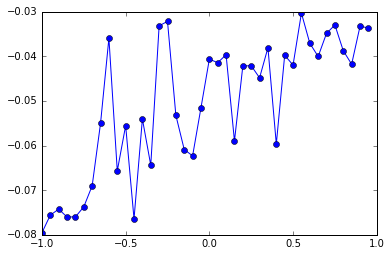

In [25]:
#Graph CMI with first approach
plt.plot(corrs, CMI_aver, 'bo-')